In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [6]:
df =pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index =pd.to_datetime(df.index)

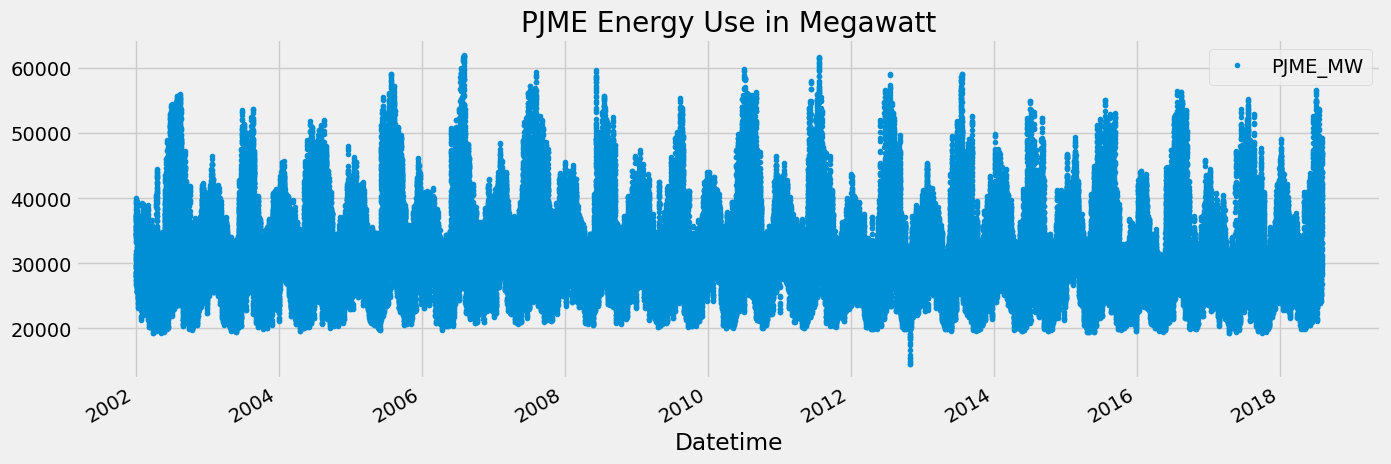

In [7]:
df.plot(style= '.', figsize = (15,5), color = color_pal[0], title= 'PJME Energy Use in Megawatt')
plt.show()

# Train / Test Split

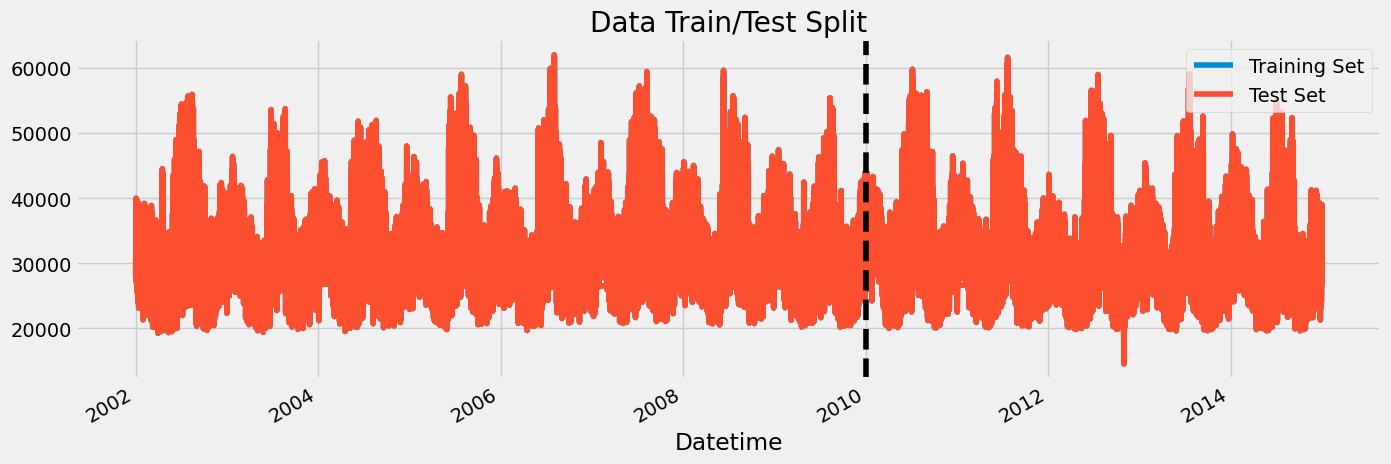

In [8]:
train= df.loc[df.index < '01-01-2015']
test= df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax, label = 'Training Set', title = 'Data Train/Test Split')
train.plot(ax=ax, label = 'Test Set')
ax.axvline('01-01-2010', color= 'black', ls ='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


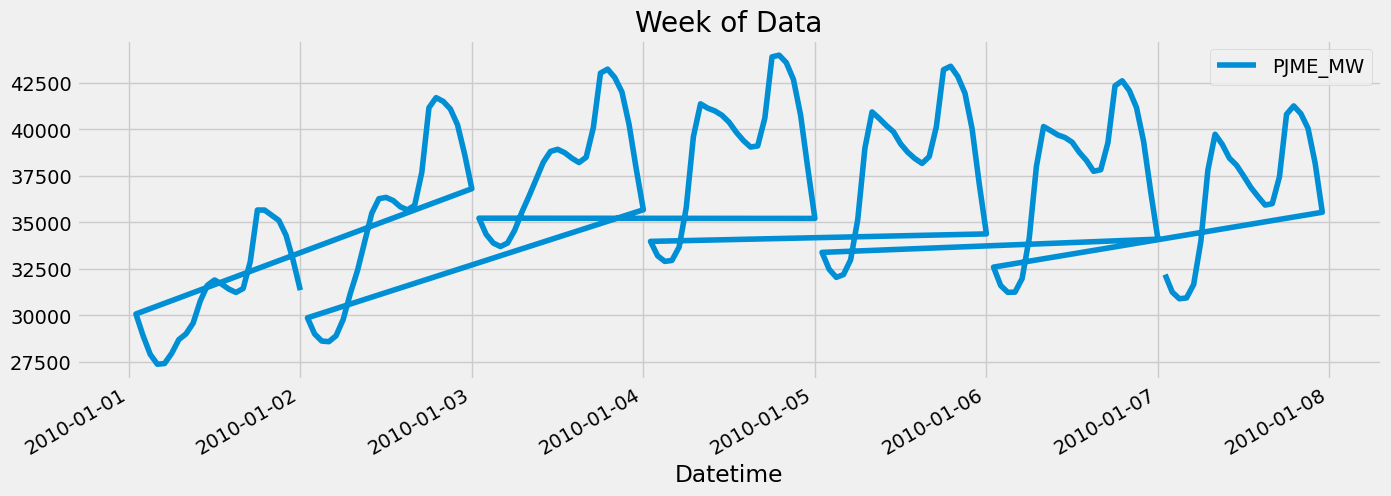

In [9]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title= 'Week of Data')
plt.show()

In [10]:
def create_features(df):

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek 
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

# Visualize our Feature / Target Relations

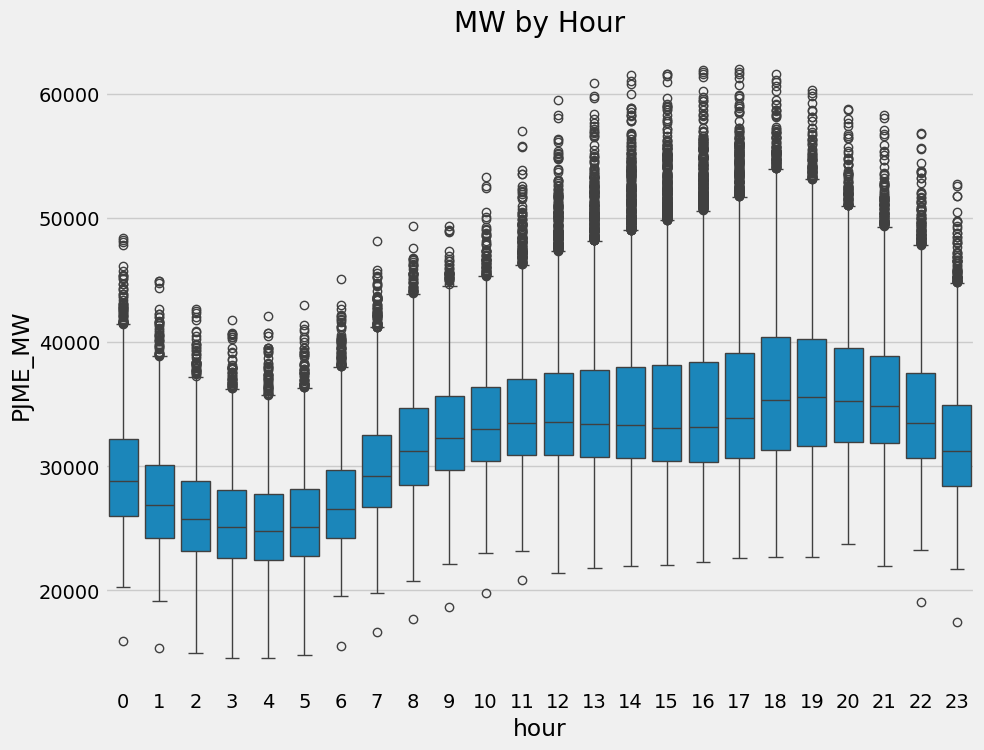

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y= 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

# Create the Model

In [12]:
train = create_features(train)
test = create_features(test)

In [13]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
target = 'PJME_MW'

In [14]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [15]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds= 50, learning_rate = 0.01)
reg.fit(X_train, y_train, eval_set= [(X_train, y_train), (X_test, y_test)], verbose = 100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Feature Importance

In [18]:
f1 = pd.DataFrame(data=reg.feature_importances_, index= reg.feature_names_in_,columns=['importance'])

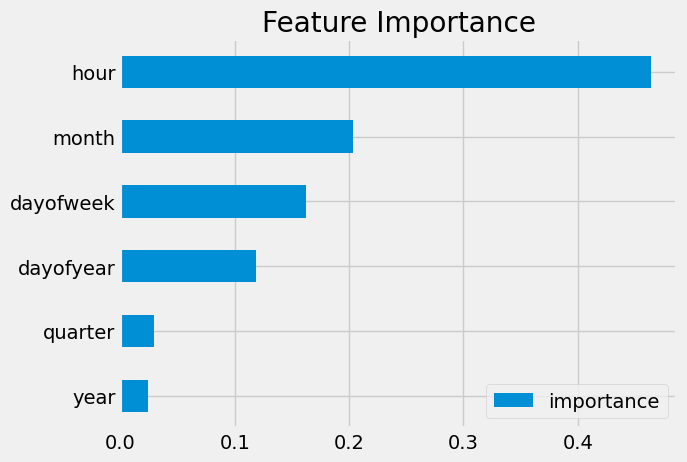

In [20]:
f1.sort_values('importance').plot(kind='barh',title= 'Feature Importance')
plt.show()

# Forecast on Test

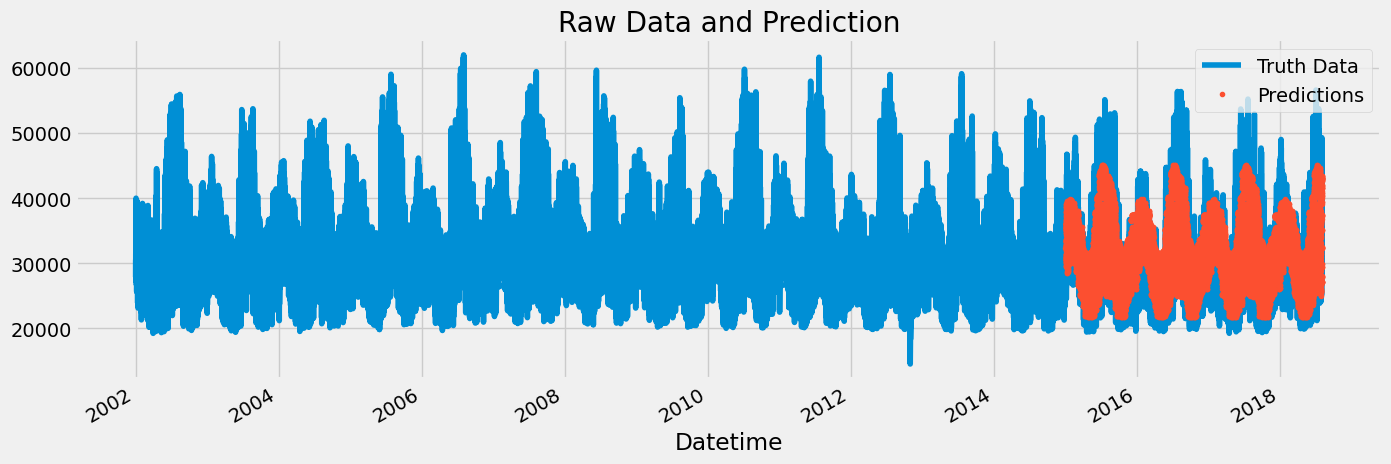

In [28]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how = 'left', left_index= True, right_index= True)
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

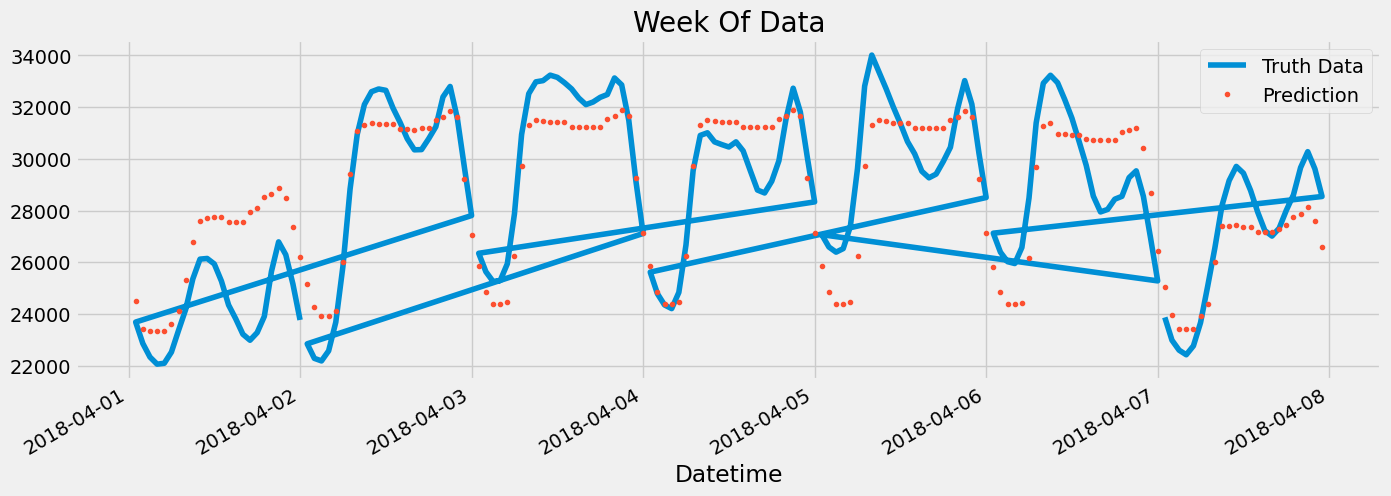

In [29]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# RSME

In [30]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3741.03


Calculating Error

In [32]:
test['error'] = np.abs(test[target] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
2018-01-06    10407.698161
2015-02-20    10143.611491
2017-05-19     9495.122640
2016-07-04     9440.610596
2016-07-23     9362.332682
Name: error, dtype: float64

# Improvement Steps for Model
- Better and robust cross validation
- Add more features(weather,holiday's)